In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
from statistics import mean
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from impyute.imputation import cs

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

In [27]:
def get_metrics(y_test, y_pred, X_cols=235):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adj_r_squared = 1 - (1-r_squared)*(len(y_test) - 1)/(len(y_test) - X_cols -1)
    return  {
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'mse': metrics.mean_squared_error(y_test, y_pred),
        'msle': metrics.mean_squared_log_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        '_r_squared': r_squared,
        '_adj_r_squared': adj_r_squared,
    }

def print_metrics(y_test, y_pred):
    res = get_metrics(y_test, y_pred)
    for key in res:
        print(f'{key}: {res[key]}')
    return res

In [28]:
df = pd.read_csv('16 df_gender.csv')

In [29]:
list(df.columns)

['budget',
 'META__id',
 'PROCESS__original_language',
 'runtime',
 'spoken_languages',
 'META__year',
 'META__month',
 'META__day',
 'weekend',
 'META__collection_name',
 'META__cast_1_name',
 'META__cast_2_name',
 'META__cast_3_name',
 'META__cast_4_name',
 'META__cast_5_name',
 'META__cast_6_name',
 'META__cast_7_name',
 'META__cast_8_name',
 'META__crew__sound__music_editor',
 'META__crew__sound__original_music_composer',
 'META__crew__sound__sound_designer',
 'META__crew__sound__sound_effects_editor',
 'META__crew__sound__sound_re_recording_mixer',
 'META__crew__sound__supervising_sound_editor',
 'META__crew__directing__director__1',
 'META__crew__directing__script_supervisor',
 'META__crew__production__casting',
 'META__crew__production__executive_producer__1',
 'META__crew__production__producer__1',
 'META__crew__production__producer__2',
 'META__crew__editing__editor__1',
 'META__crew__costume__costume_designer',
 'META__crew__costume__costume_supervisor',
 'META__crew__costume

In [30]:
shuffled_df = shuffle(df, random_state=0)

In [31]:
num_in_train = int(shuffled_df.shape[0]*0.8)

In [32]:
df_train = shuffled_df[:num_in_train]
df_test = shuffled_df[num_in_train:]

In [33]:
def get_train_test_profitability(df):
    dff = df[[col for col in df.columns if not 'META' in col and not 'PROCESS' in col]]
    X = dff.drop('profitability', axis=1)
    y = dff['profitability']
    return X, y

In [34]:
def get_train_test_revenue(df):
    df['revenue'] = df['META__revenue']
    dff = df[[col for col in df.columns if not 'META' in col and not 'PROCESS' in col]]
    X = dff.drop(['profitability', 'revenue'], axis=1)
    y = dff['revenue']
    return X, y

In [35]:
X_train, y_train = get_train_test_profitability(df_train)
X_test, y_test = get_train_test_profitability(df_test)
# X_train, y_train = get_train_test_revenue(df_train)
# X_test, y_test = get_train_test_revenue(df_test)

In [36]:
class Process:
    def __init__(self, X_train, X_test, y_train, y_test, imputer='mean', minmaxrange=(0,1)):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.y_train = y_train.copy().values.reshape(-1, 1)
        self.y_test = y_test.copy().values.reshape(-1, 1)
        self.imputer = imputer
        self.X_minmaxscaler = MinMaxScaler(feature_range=minmaxrange).fit(self.X_train)
        self.y_minmaxscaler = MinMaxScaler(feature_range=minmaxrange).fit(self.y_train)
        
    def fill_nan(self):
        def fill_train_test(imputer):
#             self.X_train[:] = imputer.fit_transform(self.X_train)
#             self.X_test[:] = imputer.fit_transform(self.X_test)
            self.X_train[:] = imputer(self.X_train.to_numpy(dtype=float))
            self.X_test[:] = imputer(self.X_test.to_numpy(dtype=float))
            
#         if (self.imputer == 'mean'):
#             fill_train_test(SimpleImputer(strategy='mean'))
#         elif (self.imputer == 'median'):
#             fill_train_test(SimpleImputer(strategy='median'))
#         elif (self.imputer == 'knn'):
#             fill_train_test(KNNImputer())
#         elif (self.imputer == 'iterative'):
#             fill_train_test(IterativeImputer(verbose=2, max_iter=20))
#         elif (self.imputer == 'iterative_mlp'):
#             fill_train_test(
#                 IterativeImputer(
#                     estimator=MLPRegressor(learning_rate='adaptive', random_state=0),
#                     verbose=2,
#                 )
#             )
        
        if (self.imputer == 'mean'):
            fill_train_test(cs.mean)
        elif (self.imputer == 'median'):
            fill_train_test(cs.median)
        elif (self.imputer == 'mode'):
            fill_train_test(cs.mode)
        elif (self.imputer == 'em'):
            fill_train_test(cs.em)
        elif (self.imputer == 'fast_knn'):
            fill_train_test(cs.fast_knn)
        return self
        
    def minmaxscaleX(self):
        self.X_train[:] = self.X_minmaxscaler.transform(self.X_train)
        self.X_test[:] = self.X_minmaxscaler.transform(self.X_test)
        return self
        
    def minmaxscaleY(self):
        self.y_train = self.y_minmaxscaler.transform(self.y_train)
        self.y_test = self.y_minmaxscaler.transform(self.y_test)
        return self

    def inverse_X_minmaxscale(self, obj):
        return self.X_minmaxscaler.inverse_transform(obj)
    
    def inverse_y_minmaxscaler(self, obj):
        return self.y_minmaxscaler.inverse_transform(obj.reshape(-1, 1)).flatten()
    
    def make_target_positive(self):
        self.min_y_train = min(self.y_train)
        self.y_train = self.y_train - self.min_y_train + 1
        self.y_test = self.y_test - self.min_y_train + 1
        return self
        
    def return_target_back_from_positive(self):
        self.y_train = self.y_train + self.min_y_train - 1
        self.y_test = self.y_test + self.min_y_train - 1
        return self
    
    def return_target_back_from_positive(self, obj):
        return obj + self.min_y_train - 1
    
    def fix_skew(self, function='log'):
        if function == 'log':
            self.y_train = np.log(self.y_train)
            self.y_test = np.log(self.y_test)
        return self
            
    def inverse_skew(self, function='log'):
        if function == 'log':
            self.y_train = np.exp(self.y_train)
            self.y_test = np.ext(self.y_test)
        return self
    
    def return_processed(self):
        return self.X_train, self.X_test, self.y_train.flatten(), self.y_test.flatten()       

In [ ]:
nan_filled_test_train = {}

results = {}
for imputer in [
#     'mean',
#     'median',
#     'knn',
#     'iterative',
#     'iterative_mlp',
#     'mean',
    'median',
#     'mode',
#     'em',
#     'fast_knn',
]:
    print(imputer)
    nan_filled_test_train[imputer] = {}
    process = Process(X_train, X_test, y_train, y_test, imputer=imputer).minmaxscaleX().fill_nan()
    train, test, _, _ = process.return_processed()
    print('processed')
    nan_filled_test_train[imputer]['train'] = train
    nan_filled_test_train[imputer]['test'] = test
    Xh_train, Xh_test, yh_train, yh_test = process.return_processed()
    
    mlp = MLPRegressor(
#         solver='adam',
#         hidden_layer_sizes=(50,),
#         activation='relu',
#         learning_rate='adaptive',
#         early_stopping=True,
        random_state=0,
        max_iter=10000,
#         tol=0.00001,
        verbose=True)

    # not scaled y
    print("training")
    mlp.fit(Xh_train, yh_train)
    predicted_y = mlp.predict(Xh_test)
    results[imputer] = {}
    results[imputer]['metrics'] = get_metrics(yh_test, predicted_y)
    results[imputer]['sample'] = pd.DataFrame({'actual':yh_test, 'predicted': predicted_y}).head(30)

from pprint import pprint
for result in results:    
    print("-----------------------------------------")
    print(result)
    pprint(results[result])

median
processed
training
Iteration 1, loss = 7540.11595948
Iteration 2, loss = 7536.97884717
Iteration 3, loss = 7533.60278674
Iteration 4, loss = 7529.65087393
Iteration 5, loss = 7524.28740885
Iteration 6, loss = 7520.31552617
Iteration 7, loss = 7514.65489588
Iteration 8, loss = 7508.90710486
Iteration 9, loss = 7503.95025660
Iteration 10, loss = 7498.97061263
Iteration 11, loss = 7493.74927769
Iteration 12, loss = 7487.50015973
Iteration 13, loss = 7482.09602396
Iteration 14, loss = 7478.24790412
Iteration 15, loss = 7474.55819533
Iteration 16, loss = 7467.88710882
Iteration 17, loss = 7463.78402999
Iteration 18, loss = 7459.15114305
Iteration 19, loss = 7454.58530686
Iteration 20, loss = 7451.20002722
Iteration 21, loss = 7446.31609632
Iteration 22, loss = 7443.07623336
Iteration 23, loss = 7439.36192196
Iteration 24, loss = 7435.30509171
Iteration 25, loss = 7430.25102352
Iteration 26, loss = 7426.59642874
Iteration 27, loss = 7422.51071704
Iteration 28, loss = 7419.35529787
Ite

Iteration 236, loss = 6664.04405408
Iteration 237, loss = 6662.21629937
Iteration 238, loss = 6657.44519849
Iteration 239, loss = 6652.45487145
Iteration 240, loss = 6643.93453147
Iteration 241, loss = 6640.42521852
Iteration 242, loss = 6638.81528260
Iteration 243, loss = 6636.91432165
Iteration 244, loss = 6629.57164015
Iteration 245, loss = 6630.37716887
Iteration 246, loss = 6623.40418273
Iteration 247, loss = 6617.67768078
Iteration 248, loss = 6609.66953098
Iteration 249, loss = 6609.31276744
Iteration 250, loss = 6606.80789890
Iteration 251, loss = 6600.91874344
Iteration 252, loss = 6599.78097265
Iteration 253, loss = 6592.68420121
Iteration 254, loss = 6591.89378173
Iteration 255, loss = 6589.88958148
Iteration 256, loss = 6578.80766659
Iteration 257, loss = 6575.12635416
Iteration 258, loss = 6577.42315223
Iteration 259, loss = 6570.39903732
Iteration 260, loss = 6563.43693258
Iteration 261, loss = 6564.27374048
Iteration 262, loss = 6559.90002369
Iteration 263, loss = 6553.1

Iteration 470, loss = 5703.97141905
Iteration 471, loss = 5696.92720266
Iteration 472, loss = 5693.38911801
Iteration 473, loss = 5693.32105112
Iteration 474, loss = 5691.07060789
Iteration 475, loss = 5684.03069385
Iteration 476, loss = 5683.10055910
Iteration 477, loss = 5670.41950492
Iteration 478, loss = 5668.21836122
Iteration 479, loss = 5664.80825310
Iteration 480, loss = 5661.31095970
Iteration 481, loss = 5655.75063480
Iteration 482, loss = 5652.54107469
Iteration 483, loss = 5648.56148327
Iteration 484, loss = 5647.01236495
Iteration 485, loss = 5641.81658801
Iteration 486, loss = 5640.49263968
Iteration 487, loss = 5646.70149880
Iteration 488, loss = 5626.74972786
Iteration 489, loss = 5622.14711557
Iteration 490, loss = 5619.26052534
Iteration 491, loss = 5624.70809960
Iteration 492, loss = 5628.62231150
Iteration 493, loss = 5609.94260343
Iteration 494, loss = 5604.60520078
Iteration 495, loss = 5602.30357687
Iteration 496, loss = 5593.56543881
Iteration 497, loss = 5591.7

Iteration 703, loss = 4773.32849815
Iteration 704, loss = 4769.31288369
Iteration 705, loss = 4772.36648136
Iteration 706, loss = 4762.71788504
Iteration 707, loss = 4760.80576995
Iteration 708, loss = 4768.01385517
Iteration 709, loss = 4751.25502623
Iteration 710, loss = 4750.33832220
Iteration 711, loss = 4742.36633992
Iteration 712, loss = 4750.87792047
Iteration 713, loss = 4741.41872870
Iteration 714, loss = 4737.40320342
Iteration 715, loss = 4727.64111583
Iteration 716, loss = 4727.25417867
Iteration 717, loss = 4722.98057769
Iteration 718, loss = 4721.15310813
Iteration 719, loss = 4719.03228224
Iteration 720, loss = 4710.58413240
Iteration 721, loss = 4704.84398542
Iteration 722, loss = 4706.74757885
Iteration 723, loss = 4705.53774748
Iteration 724, loss = 4693.99108054
Iteration 725, loss = 4693.83128954
Iteration 726, loss = 4688.32418163
Iteration 727, loss = 4683.27171452
Iteration 728, loss = 4675.74605301
Iteration 729, loss = 4675.24734282
Iteration 730, loss = 4670.9

Iteration 933, loss = 3966.59418814
Iteration 934, loss = 3968.86649376
Iteration 935, loss = 3954.74254607
Iteration 936, loss = 3951.33291229
Iteration 937, loss = 3947.43459787
Iteration 938, loss = 3949.90283681
Iteration 939, loss = 3944.61782363
Iteration 940, loss = 3936.54547917
Iteration 941, loss = 3933.93998629
Iteration 942, loss = 3929.83383537
Iteration 943, loss = 3934.93249732
Iteration 944, loss = 3926.52316758
Iteration 945, loss = 3922.80526515
Iteration 946, loss = 3926.12909056
Iteration 947, loss = 3917.21670304
Iteration 948, loss = 3913.19968880
Iteration 949, loss = 3908.45917162
Iteration 950, loss = 3907.85538971
Iteration 951, loss = 3908.99340586
Iteration 952, loss = 3899.36766744
Iteration 953, loss = 3897.24293499
Iteration 954, loss = 3892.09810262
Iteration 955, loss = 3888.22001129
Iteration 956, loss = 3887.76198132
Iteration 957, loss = 3882.46271417
Iteration 958, loss = 3886.41184613
Iteration 959, loss = 3880.11832231
Iteration 960, loss = 3872.6

Iteration 1158, loss = 3300.49832438
Iteration 1159, loss = 3292.48317153
Iteration 1160, loss = 3294.96507236
Iteration 1161, loss = 3286.35369321
Iteration 1162, loss = 3283.72431009
Iteration 1163, loss = 3285.65700269
Iteration 1164, loss = 3285.43808079
Iteration 1165, loss = 3278.17908026
Iteration 1166, loss = 3275.17765938
Iteration 1167, loss = 3277.98198510
Iteration 1168, loss = 3273.18813954
Iteration 1169, loss = 3273.99415944
Iteration 1170, loss = 3268.37886070
Iteration 1171, loss = 3260.73943876
Iteration 1172, loss = 3258.07350927
Iteration 1173, loss = 3258.49186189
Iteration 1174, loss = 3253.80898840
Iteration 1175, loss = 3250.60080775
Iteration 1176, loss = 3248.45533198
Iteration 1177, loss = 3247.94597317
Iteration 1178, loss = 3242.73393370
Iteration 1179, loss = 3244.00699191
Iteration 1180, loss = 3237.31832937
Iteration 1181, loss = 3234.27072936
Iteration 1182, loss = 3232.88375648
Iteration 1183, loss = 3240.00739610
Iteration 1184, loss = 3234.30367381
I

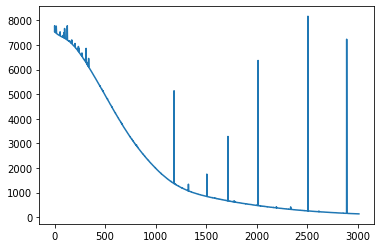

In [13]:
plt.clf()
plt.plot(mlp.loss_curve_, label='training loss')
plt.show()

In [78]:
mlp.loss_curve_

[7540.1718791034555,
 7537.0319700056325,
 7533.754645394455,
 7529.942104768904,
 7524.602844137724,
 7520.693662634879,
 7515.140347190048,
 7509.347738704537,
 7504.446913219497,
 7499.589732062205,
 7494.531401885316,
 7488.156503749506,
 7482.578502380605,
 7479.0353402589835,
 7475.861430663326,
 7468.626991427439,
 7464.288051116367,
 7460.034285970605,
 7455.503815191389,
 7451.929643087648,
 7446.857840965174,
 7444.339821006942,
 7440.389547944387,
 7436.123000127911,
 7430.904224553088,
 7427.1038879617245,
 7422.901652094723,
 7419.973234750398,
 7416.240995842854,
 7415.618174319956,
 7410.375971429389,
 7406.7261509765485,
 7404.601672323778,
 7400.376221391642,
 7399.9496870726225,
 7405.906848244931,
 7391.024815397457,
 7388.254147529891,
 7383.935721929999,
 7382.58005204327,
 7378.858200886394,
 7374.590252542295,
 7370.497730209756,
 7368.255369509828,
 7369.325206071324,
 7362.887631782816,
 7359.745762124434,
 7358.2048228335725,
 7353.615000577844,
 7347.42593746

In [79]:
mlp.validation_scores_

AttributeError: 'MLPRegressor' object has no attribute 'validation_scores_'

In [71]:
mean
{'metrics': {'mae': 19.08195794973531,
             'mse': 112199.24680258872,
             'rmse': 334.9615601865216},
 'sample':           actual  predicted
0      10.260719  -6.108725
1      22.314286   6.360902
2       6.169090  -2.005123
3       2.228443   0.877343
4      -2.077948  -0.679490
5   12889.386667  14.536277
6       2.858792   3.381179
7       7.021390   8.701726
8       2.422543  -0.846036
9      -1.208718  -8.223619
10      3.654178   3.097495
11      0.333333   1.458573
12      1.580927   3.244791
13     -0.514659  -6.394428
14      2.581429  -0.192806
15      2.817527  -0.705037
16     -0.776804   0.732113
17    -34.891114  -6.542775
18     -4.174944  -4.003411
19      0.764706   3.250370
20      2.024586   2.615100
21     -5.217105  -6.742840
22      0.750000  -1.562221
23     -1.316326  -3.604325
24     -1.328185  -4.439413
25      0.119380  -0.831240
26     -0.189060  -4.508520
27      5.641057   8.179328
28      2.891183  -5.387080
29     -0.766614  -5.534161}

SyntaxError: invalid syntax (<ipython-input-71-aec4becc5f61>, line 5)

In [38]:
list(X_train.columns)

['budget',
 'runtime',
 'spoken_languages',
 'weekend',
 'genre__war',
 'genre__western',
 'genre__mystery',
 'genre__music',
 'genre__crime',
 'genre__romance',
 'genre__action',
 'genre__adventure',
 'genre__thriller',
 'genre__animation',
 'genre__family',
 'genre__drama',
 'genre__comedy',
 'genre__documentary',
 'genre__history',
 'genre__fantasy',
 'genre__horror',
 'country__es',
 'country__jp',
 'country__us',
 'country__ca',
 'country__de',
 'country__cn',
 'country__in',
 'country__fr',
 'country__ru',
 'country__it',
 'country__au',
 'country__gb',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'cast_1_avg_profit',
 'cast_1_avg_budget',
 'cast_1_experience',
 'cast_1_avg_profitability',
 'cast_1_movies_before',
 'cast_2_avg_profit',
 'cast_2_avg_budget',
 'cast_2_experience',
 'cast_2_avg_profitability',
 'cast_2_movies_before',
 'cast_3_avg_profit',
 'cast_3_avg_budget',
 'cast_3_experience',
 'cast_3_avg_profitability',
 'cast_3_movies_before',
 'cast_4_avg_profit',


In [ ]:
# process = Process(X_train, X_test, y_train, y_test, imputer='median').fill_nan().minmaxscaleX()
process = Process(X_train, X_test, y_train, y_test, imputer='mode').minmaxscaleX().fill_nan()


# process = Process(X_train, X_test, y_train, y_test).fill_nan().minmaxscaleX().minmaxscaleY()
# process = Process(X_train, X_test, y_train, y_test).fill_nan().minmaxscaleX().fix_skew('log')

In [ ]:
Xh_train, Xh_test, yh_train, yh_test = process.return_processed()

In [ ]:
# layers = [tuple([num_neurons for i in range(num_layers)]) for num_neurons in [50, 100] for num_layers in [1, 5, 10]]
# layers = [tuple([num_neurons for i in range(num_layers)]) for num_neurons in [30, 50, 100, 300, 500] for num_layers in [1, 5, 10, 15, 20, 30]]
# layers = [tuple([num_neurons for i in range(num_layers)]) for num_neurons in [20, 40, 80, 100] for num_layers in [25, 50, 75, 100]]
# layers = [tuple([num_neurons for i in range(num_layers)]) for num_neurons in [15, 18, 20, 22, 25] for num_layers in [60, 70, 75, 80, 90]]

In [ ]:
# lbfgs: best mae = 17.906984986768954 (50 neurons, 30 layers)
# lbfgs: best mae = 17.872470267068636 (20 neurons, 75 layers)


# best mae = 17.853993928655004 ('adam', 'relu' (20 neurons, 75 layers))

In [ ]:
# best_neurons = None
# best_layers = None
# best_mae = 5000
# best_activation = None

# for activation in ['logistic', 'tanh', 'relu']:
#     for solver in ['lbfgs', 'sgd', 'adam']:
#         print(activation, solver)
mlp = MLPRegressor(
    solver='adam',
#     hidden_layer_sizes=tuple([20 for i in range(75)]),
    hidden_layer_sizes=(50,),
    activation='relu',
#     random_state=0,
    verbose=True)

# not scaled y
mlp.fit(Xh_train, yh_train)
predicted_y = mlp.predict(Xh_test)
print_metrics(yh_test, predicted_y)
pd.DataFrame({'actual':yh_test, 'predicted': predicted_y})

# scaled y
# mlp.fit(Xh_train, yh_train)
# predicted_y = mlp.predict(Xh_test)
# pred_y = process.inverse_y_minmaxscaler(predicted_y)
# actual_y = process.inverse_y_minmaxscaler(yh_test)
# print_metrics(actual_y, pred_y)
# pd.DataFrame({'actual':actual_y, 'predicted': pred_y})


# if mae < best_mae:
#     best_mae = mae
#     best_activation = activation
# print(f'best mae = {best_mae} ({best_activation} best_activation, {solver} solver')
# pd.DataFrame({'actual':actual_y, 'predicted': pred_y})

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
process = Process(X_train, X_test, y_train, y_test, imputer='mode').fill_nan().minmaxscaleX()

In [ ]:
Xh_train, Xh_test, yh_train, yh_test = process.return_processed()

In [ ]:
estimator = RandomForestRegressor(n_estimators=100, min_samples_split=3, random_state=0, n_jobs=-1)
selector = RFECV(estimator, verbose=10, n_jobs=-1)

In [ ]:
selector = selector.fit(Xh_train, yh_train)

In [ ]:
import joblib
joblib.dump(selector, 'rfecv_selector_joblib.sav')
import pickle
pickle.dump(selector, open('rfecv_selector_pickle.sav', 'wb'))

In [ ]:
selector.n_features_

In [ ]:
selector.support_

In [ ]:
selector.ranking_

In [ ]:
ind = selector.get_support()

In [ ]:
not_ind = [not val for val in ind]

In [ ]:
list(X_train.columns[ind])

In [ ]:
list(X_train.columns[not_ind])

In [ ]:
selector.score(Xh_test, yh_test)

In [ ]:
selector.score(Xh_train, yh_train)

In [ ]:
rank = [(list(X_train.columns)[i], list(selector.ranking_)[i]) for i in range(len(X_train.columns))]

In [ ]:
sorted(rank, key=lambda tup: tup[1])